
In this notebook, we will walk through implementing a simple VBLL regression model. We will first set up a basic training loop on toy data, and show the model changes required to train a model with a VBLL last layer. Finally, we will show how VBLL models can be combined with other uncertainty quantification ideas.

In [1]:
# Install vbll
!pip install vbll
import vbll

# Import necessary packages
import torch
import torch.nn as nn
import numpy as np
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

First, we will define and visualize a simple dataset.

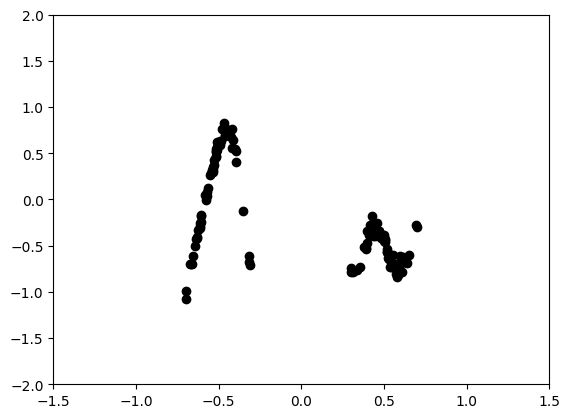

In [2]:
class SimpleFnDataset(Dataset):
    """The simple function used in DUE/SNGP 1-d regression experiments.
    Based on the implementation presented in:
    https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """

    def __init__(self, num_samples):
        self.num_samples = int(num_samples)
        self.X, self.Y = self.get_data()

    def get_data(self, noise=0.05, seed=2):
        np.random.seed(seed)

        W = np.random.randn(30, 1)
        b = np.random.rand(30, 1) * 2 * np.pi

        x = 5 * np.sign(np.random.randn(self.num_samples)) + np.random.randn(self.num_samples).clip(-2, 2)
        y = np.cos(W * x + b).sum(0)/5. + noise * np.random.randn(self.num_samples)
        return torch.tensor(x[..., None]).float()/10, torch.tensor(y[..., None]).float()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def viz_data(dataset):
    plt.scatter(dataset.X, dataset.Y, color = 'k')
    plt.axis([-1.5, 1.5, -2, 2])
    plt.show()

dataset = SimpleFnDataset(num_samples=128)

viz_data(dataset)

We will start by defining a simple MLP with a standard last layer and loss function. We will also write a viz function to plot model predictions, and a standard training loop.

In [3]:
class MLP(nn.Module):
  """
  A standard MLP regression model.

  cfg: a config containing model parameters.
  """
  def __init__(self, cfg):
    super(MLP, self).__init__()

    # define model layers
    self.params = nn.ModuleDict({
        'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
        'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
        'out_layer': nn.Linear(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES)
        })

    # ELU activations are an arbitrary choice
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

def viz_model(model, dataloader, title=None):
  """Visualize prediction of standard regression model."""
  model.eval()
  X = torch.linspace(-1.5, 1.5, 1000)[..., None]
  Y_pred = model(X)

  plt.plot(X.detach().numpy(), Y_pred.detach().numpy())
  plt.scatter(dataloader.dataset.X, dataloader.dataset.Y, color='k')
  plt.axis([-1.5, 1.5, -2, 2])
  if not title == None:
    plt.title(title)

  plt.show()

def train(dataloader, model, train_cfg, verbose = True):
  """Train a standard regression model with MSE loss."""
  loss_fn = nn.MSELoss()

  param_list = model.parameters()
  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  for epoch in range(train_cfg.NUM_EPOCHS + 1):
    model.train()
    running_loss = []

    for train_step, (x, y) in enumerate(dataloader):
      optimizer.zero_grad()

      out = model(x) # compute model output
      loss = loss_fn(out, y) # compute MSE loss

      loss.backward()
      optimizer.step()
      running_loss.append(loss.item())

    if epoch % train_cfg.VAL_FREQ == 0 and verbose:
      print('Epoch {} loss: {:.3f}'.format(epoch, np.mean(running_loss)))
      running_loss = []

Having defined the model and the train loop, we can now specify hyperparameters and train the model.

Epoch 0 loss: 0.260
Epoch 100 loss: 0.021
Epoch 200 loss: 0.017
Epoch 300 loss: 0.011
Epoch 400 loss: 0.004
Epoch 500 loss: 0.003
Epoch 600 loss: 0.004
Epoch 700 loss: 0.003
Epoch 800 loss: 0.003
Epoch 900 loss: 0.004
Epoch 1000 loss: 0.002


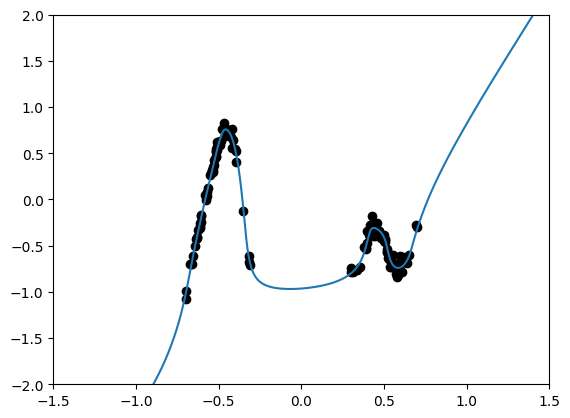

In [4]:
class train_cfg:
  NUM_EPOCHS = 1000
  BATCH_SIZE = 32
  LR = 3e-3
  WD = 0.
  OPT = torch.optim.AdamW
  VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4

dataloader = DataLoader(dataset, batch_size=train_cfg.BATCH_SIZE, shuffle=True)
model = MLP(cfg())
train(dataloader, model, train_cfg())
viz_model(model, dataloader)

As can be seen above, the model has trained and makes good prediction. However, we don't know how well it predicts far from data, and we don't have any measure of the model's uncertainty. Next, we will modify the above loop to include a VBLL last layer.

Notice that the only required change in the model definition is changing out_layer in the model params to a VBLLRegression layer. This layer also takes parameters:
- REG_WEIGHT: the KL regularization strength. By default, this should be 1/(dataset size). This term primarily impacts the last layer _epistemic_ uncertainty.
- PRIOR_SCALE: the scale of the last layer prior. This also behaves as a regularization term, and controls last layer regularization strength.
- WISHART_SCALE: regularization strengthe for the noise covariance. This term impacts the estimated _aleatoric_ uncertainty.

In [5]:
class VBLLMLP(nn.Module):
  """
  An MLP model with a VBLL last layer.

  cfg: a config containing model parameters.
  """

  def __init__(self, cfg):
    super(VBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
        'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
        'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
        'out_layer': vbll.Regression(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, prior_scale = cfg.PRIOR_SCALE, wishart_scale = cfg.WISHART_SCALE)
        })

    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

def viz_vbll_model(model, dataloader, stdevs = 1., title = None):
  """Visualize VBLL model predictions, including predictive uncertainty."""
  model.eval()
  X = torch.linspace(-1.5, 1.5, 1000)[..., None]
  Xp = X.detach().numpy().squeeze()

  Y_pred = model(X).predictive
  Y_mean = Y_pred.mean.detach().numpy().squeeze()
  Y_stdev = torch.sqrt(Y_pred.covariance.squeeze()).detach().numpy()

  plt.plot(Xp, Y_mean)
  plt.fill_between(Xp, Y_mean - stdevs * Y_stdev, Y_mean + stdevs * Y_stdev, alpha=0.2, color='b')
  plt.fill_between(Xp, Y_mean - 2 * stdevs * Y_stdev, Y_mean + 2 * stdevs * Y_stdev, alpha=0.2, color='b')
  plt.scatter(dataloader.dataset.X, dataloader.dataset.Y, color='k')
  plt.axis([-1.5, 1.5, -2, 2])
  if not title == None:
    plt.title(title)

  plt.show()



Next, we will define our train loop. This is nearly identical to the standard training loop, with a couple critical differences. First, we set weight decay on the last layer to zero. This is theoretically principled and sometimes improves performance, but is not necessary.

The VBLL model returns a dataclass containing functions used for training and evaluation. In particular, this dataclass contains both the predictive distribution (which can be to, for example, visualize the model), the training loss, and the validation loss. Since the train loss consists of a lower bound on the marginal likelihood, the train loss and the validation loss _are not the same_.

Finally, we include gradient clipping in this train loop. It is strongly recommended that you use gradient clipping with VBLL models. Optimizing covariances can be less numerically stable than standard models, but gradient clipping effectively stabilizes training.

In [6]:
def train_vbll(dataloader, model, train_cfg, verbose = True):
  """Train a VBLL model."""

  # We explicitly list the model parameters and set last layer weight decay to 0
  # This isn't critical but can help performance.
  param_list = [
      {'params': model.params.in_layer.parameters(), 'weight_decay': train_cfg.WD},
      {'params': model.params.core.parameters(), 'weight_decay': train_cfg.WD},
      {'params': model.params.out_layer.parameters(), 'weight_decay': 0.}
  ]

  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  for epoch in range(train_cfg.NUM_EPOCHS + 1):
    model.train()
    running_loss = []

    for train_step, (x, y) in enumerate(dataloader):
      optimizer.zero_grad()
      out = model(x)
      loss = out.train_loss_fn(y) # note we use the output of the VBLL layer for the loss

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg.CLIP_VAL)
      optimizer.step()
      running_loss.append(loss.item())

    if epoch % train_cfg.VAL_FREQ == 0 and verbose:
      print('Epoch: {:4d},  loss: {:10.4f}'.format(epoch, np.mean(running_loss)))
      running_loss = []

Epoch:    0,  loss:     9.0380
Epoch:  100,  loss:     1.1825
Epoch:  200,  loss:     0.8222
Epoch:  300,  loss:     0.5296
Epoch:  400,  loss:     0.3261
Epoch:  500,  loss:     0.2124
Epoch:  600,  loss:     0.0471
Epoch:  700,  loss:    -0.1281
Epoch:  800,  loss:    -0.3459
Epoch:  900,  loss:    -0.4347
Epoch: 1000,  loss:    -0.5648


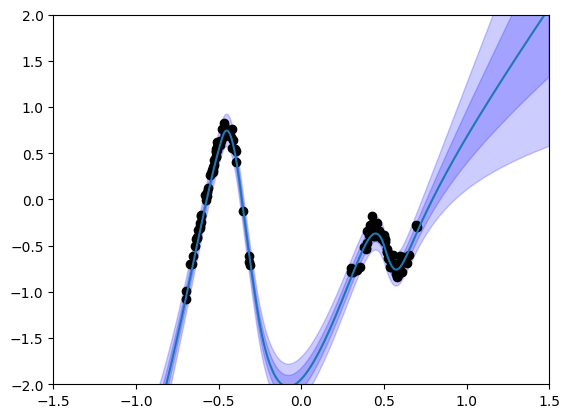

In [7]:
class train_cfg:
  NUM_EPOCHS = 1000
  BATCH_SIZE = 32
  LR = 1e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    OUT_FEATURES = 1
    NUM_LAYERS = 4
    REG_WEIGHT = 1./dataset.__len__()
    PARAM = 'dense'
    PRIOR_SCALE = 1.
    WISHART_SCALE = .1

vbll_model = VBLLMLP(cfg())
train_vbll(dataloader, vbll_model, train_cfg())
viz_vbll_model(vbll_model, dataloader)

Above, we visualize the trained VBLL models. You can see that we effectively represent uncertainty far from the data.

What if the uncertainty doesn't match our expectations or goals? There are several ways to control uncertainty within VBLL models. The simplest and most effective method to control the scale of uncertainty that we have found is modifying the KL regularization weight, REG_WEIGHT. We can train a different VBLL model with a larger REG_WEIGHT:

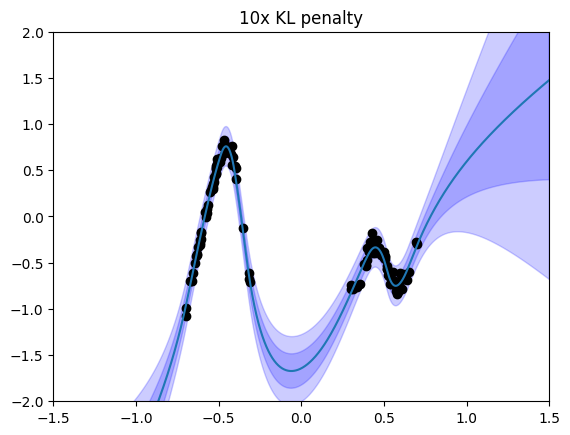

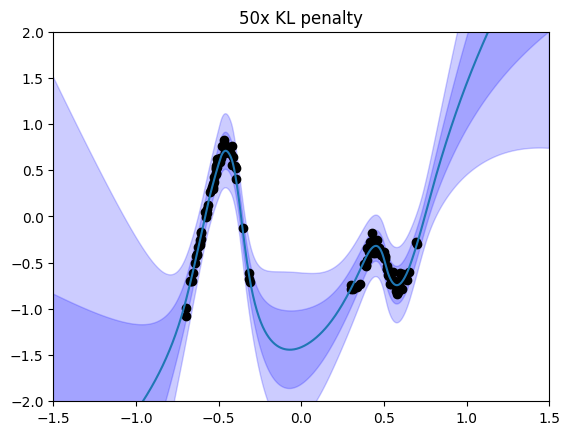

In [8]:
new_cfg = deepcopy(cfg())
new_cfg.REG_WEIGHT *= 10

vbll_model = VBLLMLP(new_cfg)
train_vbll(dataloader, vbll_model, train_cfg(), verbose = False)
viz_vbll_model(vbll_model, dataloader, title='10x KL penalty')

new_cfg = deepcopy(cfg())
new_cfg.REG_WEIGHT *= 50

vbll_model = VBLLMLP(new_cfg)
train_vbll(dataloader, vbll_model, train_cfg(), verbose = False)
viz_vbll_model(vbll_model, dataloader, title='50x KL penalty')

We can pair VBLL last layers with other forms of uncertainty quantification. Effective methods include Bayesian feature learning via Bayes-by-backprop, dropout, or ensembles. One simple strategy it to control the features used in Bayesian regression. We build upon SNGP (Liu et al., JMLR 2022). In particular, we add three modifications:
- A residual structure, in which layers are additive on a residual connection
- Spectral normalization of layers
- Random Fourier features as a last nonlinearity.

In SNGP, the authors use an ad-hoc method for computing the last layer covariance. Here, we can combine the SNGP feature structure with VBLL last layer learning.

Epoch:    0,  loss:     4.5267
Epoch:  100,  loss:     1.2557
Epoch:  200,  loss:     0.5975
Epoch:  300,  loss:    -0.0657
Epoch:  400,  loss:    -0.0670
Epoch:  500,  loss:    -0.3947
Epoch:  600,  loss:    -0.3022
Epoch:  700,  loss:    -0.4313
Epoch:  800,  loss:    -0.5919
Epoch:  900,  loss:    -0.5676
Epoch: 1000,  loss:    -0.4588


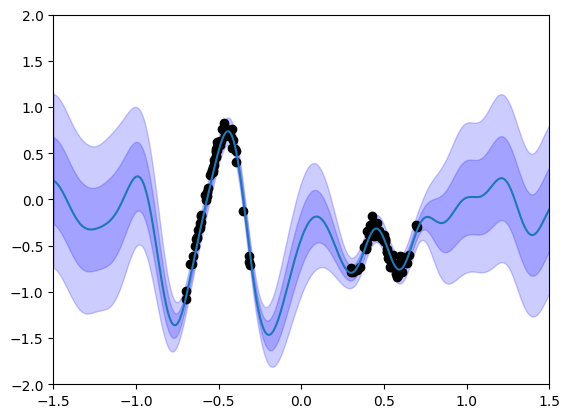

In [9]:
from torch.nn.utils.parametrizations import spectral_norm
class SNVResMLP(nn.Module):
  def __init__(self, cfg):
    super(SNVResMLP, self).__init__()
    self.cfg = cfg
    self.params = nn.ModuleDict({
        'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
        'core': nn.ModuleList([spectral_norm(nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES)) for i in range(cfg.NUM_LAYERS)]),
        'out_layer': vbll.Regression(cfg.RFF_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, prior_scale = cfg.PRIOR_SCALE, wishart_scale = cfg.WISHART_SCALE)
        })

    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS-1)])
    self.W = torch.normal(torch.zeros(cfg.RFF_FEATURES, cfg.HIDDEN_FEATURES), cfg.KERNEL_SCALE * torch.ones(cfg.RFF_FEATURES, cfg.HIDDEN_FEATURES))
    self.b = torch.rand(cfg.RFF_FEATURES)*2*torch.pi

  def forward(self, x):
    x =  self.params['in_layer'](x)
    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x)) + x

    x = torch.cos((self.W @ x[..., None]).squeeze(-1) + self.b)
    x = x * np.sqrt(2./self.cfg.RFF_FEATURES) * (self.cfg.KERNEL_SCALE)

    return self.params['out_layer'](x)

class train_cfg:
  NUM_EPOCHS = 1000
  BATCH_SIZE = 32
  LR = 3e-3
  WD = 0.
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 100

class cfg:
    IN_FEATURES = 1
    HIDDEN_FEATURES = 64
    RFF_FEATURES = 128
    OUT_FEATURES = 1
    DROPOUT_RATE = 0.0
    NUM_LAYERS = 4
    REG_WEIGHT = 1./dataset.__len__()
    PRIOR_SCALE = 1.
    WISHART_SCALE = .1
    KERNEL_SCALE = .5

dataloader = DataLoader(dataset, batch_size=train_cfg.BATCH_SIZE, shuffle=True)
snv_model = SNVResMLP(cfg())
train_vbll(dataloader, snv_model, train_cfg())
viz_vbll_model(snv_model, dataloader)